In [2]:
import os
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Set the display option to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data_folder = '/content/drive/MyDrive/Dataset/data'
step_data_frames = []

# Loop through the data folder and its subfolders
for root, dirs, files in os.walk(data_folder):
    for filename in files:
        # Check if the file is a .csv file
        if filename.endswith('.csv'):
            csv_path = os.path.join(root, filename)
            step_mixed_path = os.path.join(root, filename.replace("Clipped", "") + '.stepMixed')

            # Check if the corresponding .csv.stepMixed file exists
            if os.path.exists(step_mixed_path):
                # Read the .csv file
                step_data = pd.read_csv(csv_path, usecols=[1, 2, 3, 4, 5, 6])
                step_data = step_data.dropna()  # Removes missing values

                # Reads StepIndices value - Start and End index of a step
                col_names = ['start_index', 'end_index']
                step_indices = pd.read_csv(step_mixed_path, names=col_names)

                # Removing missing values and outliers
                step_indices = step_indices.dropna()
                step_indices = step_indices.loc[(step_indices.end_index < step_data.shape[0])]

                # Create a labels column and initialize with default value
                step_data["Label"] = "No Label"

                # Assign "start" and "end" labels to corresponding rows
                for index, row in step_indices.iterrows():
                    step_data.loc[row['start_index'], "Label"] = "start"
                    step_data.loc[row['end_index'], "Label"] = "end"

                # Append the DataFrame to the list
                step_data_frames.append(step_data)


# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(step_data_frames, ignore_index=True)
print(combined_df.shape)
test_path = os.path.join(data_folder,"testdata.csv")
test_df = pd.read_csv(test_path)

(722582, 7)


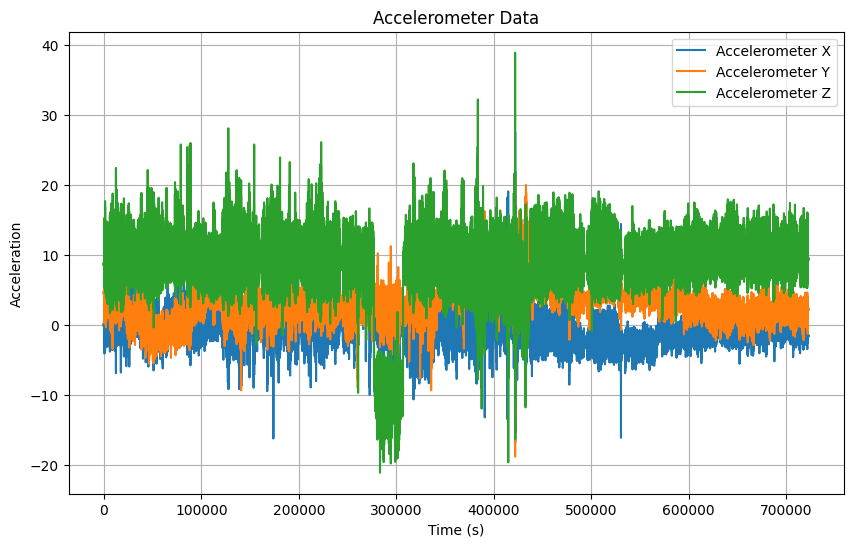

In [3]:
# Generate array of times
time = np.arange(0,722582)
# Plot accelerometer data
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.plot(time, combined_df.iloc[:,0], label='Accelerometer X')
plt.plot(time, combined_df.iloc[:,1], label='Accelerometer Y')
plt.plot(time, combined_df.iloc[:,2], label='Accelerometer Z')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration')
plt.title('Accelerometer Data')
plt.legend()
plt.grid(True)
plt.show()

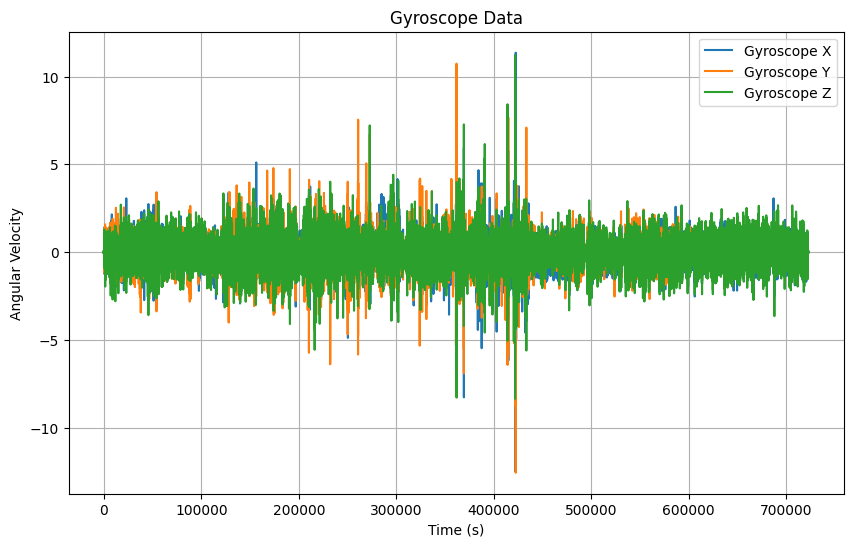

In [4]:
# Plot Gyroscope data
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.plot(time, combined_df.iloc[:,3], label='Gyroscope X')
plt.plot(time, combined_df.iloc[:,4], label='Gyroscope Y')
plt.plot(time, combined_df.iloc[:,5], label='Gyroscope Z')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity')
plt.title('Gyroscope Data')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
class StepDetectionDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.features = self.data.iloc[:, :6].values  # Extract the features
        self.labels = self.data.iloc[:, 6].values  # Extract the labels

        self.label_mapping = {'No Label': 0, 'start': 1, 'end': 2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = torch.tensor(self.features[index], dtype=torch.float32)
        label = torch.tensor(self.label_mapping[self.labels[index]])

        return features, label


class StepDetectionTestDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.features = self.data.iloc[:, :6].values  # Extract the features

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = torch.tensor(self.features[index], dtype=torch.float32)
        return features

# Create the train, validation, test dataset
dataset = StepDetectionDataset(combined_df)
test_dataset = StepDetectionTestDataset(test_df)
print(test_df.shape)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

(102091, 6)


In [6]:
# Define the LSTM model
class StepDetectionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.0):
        super(StepDetectionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        self.lstm_layers.append(nn.LSTM(input_size, hidden_size, batch_first=True))
        self.dropout_layers.append(nn.Dropout(dropout))

        for _ in range(1, num_layers):
            self.lstm_layers.append(nn.LSTM(hidden_size, hidden_size, batch_first=True))
            self.dropout_layers.append(nn.Dropout(dropout))

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        hiddens = []
        for layer in range(self.num_layers):
            out, _ = self.lstm_layers[layer](x)
            x = self.dropout_layers[layer](out)
            hiddens.append(out[:, -1, :])

        hidden = torch.stack(hiddens, dim=0).sum(dim=0)
        out = self.fc(hidden)

        return out

In [7]:
# Define the hyperparameters
input_size = 6
num_classes = 3
batch_size = 64
num_epochs = 5
learning_rate = 0.001
num_layers = 6
hidden_size = 256
dropout = 0.5

In [8]:
# Initialize the LSTM model
model = StepDetectionLSTM(input_size, hidden_size, num_layers, num_classes, dropout=dropout)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Function to calculate the accuracy of the model
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [ ]:
# Training loop
# Initialize empty lists to store loss values
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0

    for i, (features, labels) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(features.unsqueeze(1))
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_accuracy += calculate_accuracy(outputs, labels)

    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(features.unsqueeze(1))
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_accuracy += calculate_accuracy(outputs, labels)

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)
    val_losses.append(val_loss)

    # Print training and validation results for each epoch
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch 1/10, Train Loss: 0.1624, Train Accuracy: 0.9644, Val Loss: 0.1571, Val Accuracy: 0.9645
Epoch 2/10, Train Loss: 0.1547, Train Accuracy: 0.9644, Val Loss: 0.1535, Val Accuracy: 0.9645
Epoch 3/10, Train Loss: 0.1524, Train Accuracy: 0.9644, Val Loss: 0.1527, Val Accuracy: 0.9645
Epoch 4/10, Train Loss: 0.1510, Train Accuracy: 0.9644, Val Loss: 0.1498, Val Accuracy: 0.9645
Epoch 5/10, Train Loss: 0.1503, Train Accuracy: 0.9644, Val Loss: 0.1525, Val Accuracy: 0.9645
Epoch 6/10, Train Loss: 0.1498, Train Accuracy: 0.9644, Val Loss: 0.1496, Val Accuracy: 0.9645
Epoch 7/10, Train Loss: 0.1495, Train Accuracy: 0.9644, Val Loss: 0.1487, Val Accuracy: 0.9645
Epoch 8/10, Train Loss: 0.1491, Train Accuracy: 0.9644, Val Loss: 0.1495, Val Accuracy: 0.9645
Epoch 9/10, Train Loss: 0.1490, Train Accuracy: 0.9644, Val Loss: 0.1486, Val Accuracy: 0.9645
Epoch 10/10, Train Loss: 0.1488, Train Accuracy: 0.9644, Val Loss: 0.1486, Val Accuracy: 0.9645


In [19]:
# Test the model
model.eval()
predictions = []

with torch.no_grad():
    for features in test_loader:
        features = features.to(device)
        outputs = model(features.unsqueeze(1))
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Convert predictions to labels
labels_mapping = {v: k for k, v in dataset.label_mapping.items()}
predicted_labels = [labels_mapping[prediction] for prediction in predictions]

In [20]:
def test(model, dataloader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs.unsqueeze(1))
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            predictions.extend(probabilities)

    return predictions

def write_output_file(file_path, predictions):
    with open(file_path, 'w') as file:
        file.write('index,start,end\n')
        for time_point, pred in enumerate(predictions):
            start_prob = pred[1]  # Probability of being the start of a step
            end_prob = pred[2]  # Probability of being the end of a step
            line = f'{time_point},{start_prob:.6f},{end_prob:.6f}\n'
            file.write(line)

In [21]:
# Test the model and write predictions to an output file
output_file = '/content/sample_data/step_predictions_LSTM.csv'
test_predictions = test(model, test_loader, device)
write_output_file(output_file, test_predictions)

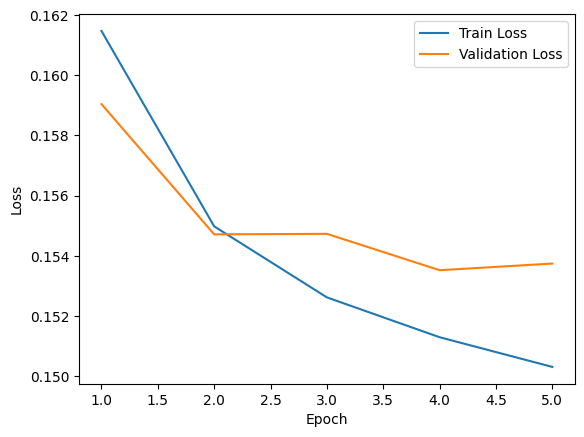

In [22]:
# Plot the graph
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()